In [1]:
import socket
print(socket.gethostname())


ip-10-0-4-176


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, 
    roc_auc_score, precision_recall_fscore_support
)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from tqdm import tqdm
import re
import warnings
import os
import json
import time
import joblib
from bs4 import BeautifulSoup
import unicodedata
import multiprocessing
multiprocessing.set_start_method('fork', force=True)


import sys, os
sys.path.append(os.path.abspath('.'))


from email_dataset import EmailDataset

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data loading and Preprocessing

In [3]:
# Masking special tokens
def mask_tokens(text):
    """Mask URLs, files, emails, money, and numbers"""
    text = re.sub(r'(https?://\S+|www\.\S+)', '<URL>', text)
    text = re.sub(r'\b[\w\-]+\.(pdf|docx|xlsx|txt|csv|tar|doc\.gz|doc)\b', '<FILE>', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '<EMAIL>', text)
    text = re.sub(r'\$\d+(?:\.\d{2})?', '<MONEY>', text)
    text = re.sub(r'\b\d+\b', '<NUMBER>', text)
    text = text.replace('<NUMBER>', '')
    return text

# Strip HTML
def strip_html(raw_html):
    """Strip HTML tags and extract clean text"""
    soup = BeautifulSoup(raw_html, "html.parser")
    
    for a in soup.find_all("a"):
        href = a.get("href", None)
        if not href:
            continue
        a_attribute = mask_tokens(href)
        if a_attribute == '<URL>':
            a.replace_with('<URL>')
        elif a_attribute == '<EMAIL>':
            a.replace_with('<EMAIL>')
        elif a_attribute == '<FILE>':
            a.replace_with('<FILE>')
        elif a_attribute == '<MONEY>':
            a.replace_with('<MONEY>')
    
    for tag in soup(["script", "style", "head", "title", "meta", "[document]"]):
        tag.decompose()
    
    text = soup.get_text(separator=" ")
    text = unicodedata.normalize("NFKC", text)
    text = text.replace("\xa0", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Deobfuscation
mapper = str.maketrans({
    '0':'o', '1':'l', '3':'e', '4':'a', '5':'s', '7':'t', '$':'s', '@':'a'
})

def deobfuscate_words(text):
    """Replace leetspeak and remove weird spacing"""
    text = text.translate(mapper)
    text = re.sub(r'(?i)(?<=\w)[^A-Za-z0-9\s]{1,3}(?=\w)', '', text)
    return text

def word_capper(text):
    """Cap repeated characters"""
    text = re.sub(r'(.)\1{2,}', lambda m: m.group(1)*2, text)
    text = re.sub(r'([!?.,])\1{1,}', r'\1\1', text)
    return text

def char_lvl_whitelist_filter(text):
    """Whitelist filtering"""
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\'\":;\-\_\(\)\@\#\$\%\^\&\<\>]', '', text)
    return text

def final_punc_removal(text):
    """Final punctuation cleanup"""
    text = re.sub(r'[^A-Za-z0-9\s<>]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_email_text(raw):
    """Complete preprocessing pipeline"""
    if pd.isna(raw) or raw == '':
        return ""
    raw = str(raw)
    raw = strip_html(raw)
    raw = mask_tokens(raw)
    raw = deobfuscate_words(raw)
    raw = word_capper(raw)
    raw = char_lvl_whitelist_filter(raw)
    raw = final_punc_removal(raw)
    raw = raw.lower()
    if len(raw) < 10:
        return ""
    return raw

def preprocess_email_df(df, text_col):
    """Apply preprocessing to entire dataframe"""
    df[text_col] = df[text_col].apply(preprocess_email_text)
    # Remove empty texts
    df = df[df[text_col] != ""].reset_index(drop=True)
    return df


## Create Dataset class

In [4]:
# class EmailDataset(Dataset):
#     """Custom PyTorch Dataset for email data"""
    
#     def __init__(self, texts, labels, tokenizer, max_length=512):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length
    
#     def __len__(self):
#         return len(self.texts)
    
#     def __getitem__(self, idx):
#         text = str(self.texts[idx])
#         label = int(self.labels[idx])
        
#         encoding = self.tokenizer(
#             text,
#             padding='max_length',
#             truncation=True,
#             max_length=self.max_length,
#             return_tensors='pt'
#         )
        
#         return {
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'label': torch.tensor(label, dtype=torch.long)
#         }

## Run distilbert with LoRA Finetuning

In [5]:
class DistilBERTLoRAEncoder(nn.Module):
    """DistilBERT-based encoder with LoRA for parameter-efficient fine-tuning"""
    
    def __init__(self, lora_config=None, use_lora=True):
        super(DistilBERTLoRAEncoder, self).__init__()
        
        # Load base DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.use_lora = use_lora
        
        if use_lora:
            # Default LoRA configuration if not provided
            if lora_config is None:
                lora_config = LoraConfig(
                    r=8,
                    lora_alpha=16,
                    target_modules=["q_lin", "v_lin"],
                    lora_dropout=0.1,
                    bias="none",
                    task_type=TaskType.FEATURE_EXTRACTION
                )
            
            # Apply LoRA to the model
            self.distilbert = get_peft_model(self.distilbert, lora_config)
            self.print_trainable_parameters()
        else:
            # Freeze all parameters if not using LoRA
            for param in self.distilbert.parameters():
                param.requires_grad = False
    
    def print_trainable_parameters(self):
        """Print the number of trainable parameters"""
        if self.use_lora:
            trainable_params = 0
            all_param = 0
            for _, param in self.distilbert.named_parameters():
                all_param += param.numel()
                if param.requires_grad:
                    trainable_params += param.numel()
            
            print(f"\nLoRA Parameter Efficiency:")
            print(f"  Trainable params: {trainable_params:,}")
            print(f"  All params: {all_param:,}")
            print(f"  Trainable%: {100 * trainable_params / all_param:.2f}%")
    
    def forward(self, input_ids, attention_mask):
        """Extract hidden states from DistilBERT with LoRA"""
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use [CLS] token representation (first token)
        hidden_states = outputs.last_hidden_state[:, 0, :]
        return hidden_states

## Load and preprocess data

In [6]:
# Load raw data
train_df_raw = pd.read_csv('/home/ubuntu/projects/dione/DistilBERT_pipeline/raw_encoder_data_sets/train_set.csv')
val_df_raw = pd.read_csv('/home/ubuntu/projects/dione/DistilBERT_pipeline/raw_encoder_data_sets/valid_set.csv')
test_df_raw = pd.read_csv('/home/ubuntu/projects/dione/DistilBERT_pipeline/raw_encoder_data_sets/test_set.csv')

print("Raw data shapes:")
print(f"Train: {train_df_raw.shape}")
print(f"Val: {val_df_raw.shape}")
print(f"Test: {test_df_raw.shape}")

# Preprocess
text_col = "text_combined"
train_df = preprocess_email_df(train_df_raw.copy(), text_col)
val_df = preprocess_email_df(val_df_raw.copy(), text_col)
test_df = preprocess_email_df(test_df_raw.copy(), text_col)

# Remove overlaps (Train → Val → Test hierarchy)
train_texts = set(train_df[text_col])
val_df = val_df[~val_df[text_col].isin(train_texts)].reset_index(drop=True)
val_texts = set(val_df[text_col])
test_df = test_df[~test_df[text_col].isin(train_texts.union(val_texts))].reset_index(drop=True)

print("\nCleaned data shapes:")
print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Test: {test_df.shape}")

# Verify no overlaps
print(f"\nOverlap checks (should all be 0):")
print(f"Train-Val: {len(set(train_df[text_col]) & set(val_df[text_col]))}")
print(f"Train-Test: {len(set(train_df[text_col]) & set(test_df[text_col]))}")
print(f"Val-Test: {len(set(val_df[text_col]) & set(test_df[text_col]))}")

# Save cleaned data
os.makedirs('clean_data_distilbert', exist_ok=True)
train_df.to_csv('clean_data_distilbert/train_clean.csv', index=False)
val_df.to_csv('clean_data_distilbert/val_clean.csv', index=False)
test_df.to_csv('clean_data_distilbert/test_clean.csv', index=False)

Raw data shapes:
Train: (65662, 2)
Val: (8208, 2)
Test: (8208, 2)

Cleaned data shapes:
Train: (65655, 2)
Val: (8060, 2)
Test: (8056, 2)

Overlap checks (should all be 0):
Train-Val: 0
Train-Test: 0
Val-Test: 0


## DistilBERT + LoRA Finetuning

In [7]:
class DistilBERTLoRAEncoder(nn.Module):
    """DistilBERT encoder with LoRA adaptation"""
    
    def __init__(self, lora_config=None, use_lora=True):
        super(DistilBERTLoRAEncoder, self).__init__()
        
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.use_lora = use_lora
        
        if use_lora:
            if lora_config is None:
                lora_config = LoraConfig(
                    r=8,
                    lora_alpha=16,
                    target_modules=["q_lin", "v_lin"],
                    lora_dropout=0.1,
                    bias="none",
                    task_type=TaskType.FEATURE_EXTRACTION
                )
            
            self.distilbert = get_peft_model(self.distilbert, lora_config)
            self.print_trainable_parameters()
        else:
            for param in self.distilbert.parameters():
                param.requires_grad = False
    
    def print_trainable_parameters(self):
        """Print trainable parameter statistics"""
        if self.use_lora:
            trainable_params = 0
            all_param = 0
            for _, param in self.distilbert.named_parameters():
                all_param += param.numel()
                if param.requires_grad:
                    trainable_params += param.numel()
            
            print(f"LoRA Parameter Efficiency:")
            print(f"  Trainable params: {trainable_params:,}")
            print(f"  All params: {all_param:,}")
            print(f"  Trainable%: {100 * trainable_params / all_param:.2f}%")
    
    def forward(self, input_ids, attention_mask):
        """Extract [CLS] token embeddings"""
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return outputs.last_hidden_state[:, 0, :]

## Traingng helper functions

In [8]:
def seed_worker(worker_id):
    """Seed worker for DataLoader"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

def extract_features(model, dataloader, device, desc="Extracting features"):
    """Extract DistilBERT features from dataloader"""
    model.eval()
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].cpu().numpy()
            
            features = model(input_ids, attention_mask)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels)
    
    return np.vstack(all_features), np.concatenate(all_labels)

def evaluate_metrics_encoder(dl, model, device, classification_head):
    """Evaluate encoder + classification head during fine-tuning"""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].cpu().numpy()
            
            features = model(input_ids, attention_mask)
            logits = classification_head(features)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            y_true.extend(labels)
            y_pred.extend(preds)
    
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return p, r, f1, acc

def save_checkpoint(path, epoch, model, optimizer, scheduler, config, best_f1, seed):
    """Save model checkpoint"""
    state = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if scheduler is not None else None,
        "config": config,
        "best_val_f1": best_f1,
        "seed": seed,
    }
    tmp = path + ".tmp"
    torch.save(state, tmp)
    os.replace(tmp, path)

## create dataloaders

In [9]:
# Load cleaned data
train_df = pd.read_csv('clean_data_distilbert/train_clean.csv')
val_df = pd.read_csv('clean_data_distilbert/val_clean.csv')
test_df = pd.read_csv('clean_data_distilbert/test_clean.csv')

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
train_ds = EmailDataset(train_df[text_col].values, train_df['label'].values, tokenizer, max_length=256)
val_ds = EmailDataset(val_df[text_col].values, val_df['label'].values, tokenizer, max_length=256)
test_ds = EmailDataset(test_df[text_col].values, test_df['label'].values, tokenizer, max_length=256)

# Create DataLoaders
g = torch.Generator()
g.manual_seed(SEED)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      num_workers=2, pin_memory=True,
                      worker_init_fn=seed_worker, generator=g)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False,
                    num_workers=2, pin_memory=True,
                    worker_init_fn=seed_worker, generator=g)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False,
                     num_workers=2, pin_memory=True,
                     worker_init_fn=seed_worker, generator=g)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_dl)}")
print(f"  Val batches: {len(val_dl)}")
print(f"  Test batches: {len(test_dl)}")


DataLoaders created:
  Train batches: 1026
  Val batches: 63
  Test batches: 63


## Configuration

In [ ]:
CONFIG = {
    "seed": 42,
    "batch_size_train": 64,
    "batch_size_eval": 128,
    "max_length": 256,
    
    # LoRA config
    "lora_r": 8,
    "lora_alpha": 16,
    "lora_dropout": 0.1,
    "lora_target_modules": ["q_lin", "v_lin"],
    
    # Fine-tuning config
    "finetune_epochs": 10,
    "finetune_lr": 1e-3,
    "finetune_weight_decay": 1e-5,
    "patience": 3,

    
    # Logistic Regression config
    "lr_max_iter": 1000,
    "lr_C": 1.0,
    "lr_solver": "lbfgs",
    
    "num_classes": 2,
}

print("Configuration:")
print(json.dumps(CONFIG, indent=2))


Configuration:
{
  "seed": 42,
  "batch_size_train": 64,
  "batch_size_eval": 128,
  "max_length": 256,
  "lora_r": 8,
  "lora_alpha": 16,
  "lora_dropout": 0.1,
  "lora_target_modules": [
    "q_lin",
    "v_lin"
  ],
  "finetune_epochs": 10,
  "finetune_lr": 0.001,
  "finetune_weight_decay": 1e-05,
  "patience": 3,
  "lr_max_iter": 1000,
  "lr_C": 1.0,
  "lr_solver": "lbfgs",
  "num_classes": 2
}


## Initialise model

In [11]:
# LoRA configuration
lora_config = LoraConfig(
    r=CONFIG["lora_r"],
    lora_alpha=CONFIG["lora_alpha"],
    target_modules=CONFIG["lora_target_modules"],
    lora_dropout=CONFIG["lora_dropout"],
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION
)

# Initialize encoder
encoder = DistilBERTLoRAEncoder(lora_config=lora_config, use_lora=True).to(device)

LoRA Parameter Efficiency:
  Trainable params: 147,456
  All params: 66,510,336
  Trainable%: 0.22%


## Finetuning

In [12]:
# Temporary classification head for fine-tuning
classification_head = nn.Linear(768, CONFIG["num_classes"]).to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(
    list(encoder.parameters()) + list(classification_head.parameters()),
    lr=CONFIG["finetune_lr"],
    weight_decay=CONFIG["finetune_weight_decay"]
)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=1
)

# Training loop
best_val_f1 = -1.0
best_val_loss = float("inf")
no_improve = 0
finetune_history = []

CKPT_DIR = "checkpoints_distilbert"
BEST_CKPT_DIR = "best_ckpts_distilbert"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(BEST_CKPT_DIR, exist_ok=True)

for epoch in range(1, CONFIG["finetune_epochs"] + 1):
    # Training
    encoder.train()
    classification_head.train()
    running_loss = 0.0
    
    train_pbar = tqdm(train_dl, desc=f"Epoch {epoch:02d} [Train]", leave=False)
    for batch in train_pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        features = encoder(input_ids, attention_mask)
        logits = classification_head(features)
        loss = criterion(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        train_pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    train_loss_avg = running_loss / len(train_dl)
    
    # Validation
    encoder.eval()
    classification_head.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        val_pbar = tqdm(val_dl, desc=f"Epoch {epoch:02d} [Val]", leave=False)
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            features = encoder(input_ids, attention_mask)
            logits = classification_head(features)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            val_pbar.set_postfix(vloss=f"{loss.item():.4f}")
    
    val_loss_avg = val_loss / len(val_dl)
    p, r, val_f1, acc = evaluate_metrics_encoder(val_dl, encoder, device, classification_head)
    scheduler.step(val_loss_avg)
    
    # Record metrics
    finetune_history.append({
        "epoch": epoch,
        "train_loss": float(train_loss_avg),
        "val_loss": float(val_loss_avg),
        "val_precision": float(p),
        "val_recall": float(r),
        "val_F1": float(val_f1),
        "val_accuracy": float(acc),
    })
    
    print(f"epoch {epoch:02d} | train_loss={train_loss_avg:.4f} | val_loss={val_loss_avg:.4f} | "
          f"P={p:.4f} | R={r:.4f} | F1={val_f1:.4f}")
    
    # Save checkpoint
    save_checkpoint(
        os.path.join(CKPT_DIR, f"finetune_epoch_{epoch:02d}.pt"),
        epoch, encoder, optimizer, scheduler, CONFIG, best_val_f1, SEED
    )
    
    # Track best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_checkpoint(
            os.path.join(BEST_CKPT_DIR, "best_finetune.pt"),
            epoch, encoder, optimizer, scheduler, CONFIG, best_val_f1, SEED
        )
        print(f"  ✓ New best F1: {best_val_f1:.4f}")
    
    # Early stopping
    if val_loss_avg < best_val_loss - 1e-5:
        best_val_loss = val_loss_avg
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= CONFIG["patience"]:
            print(f"Early stopping at epoch {epoch}")
            break

# Save fine-tuning history
finetune_df = pd.DataFrame(finetune_history)
finetune_df.to_csv(os.path.join(CKPT_DIR, "finetune_history.csv"), index=False)
print(f"\nBest validation F1 during fine-tuning: {best_val_f1:.4f}")


epoch 01 | train_loss=0.0828 | val_loss=0.0389 | P=0.9830 | R=0.9916 | F1=0.9873
  ✓ New best F1: 0.9873


epoch 02 | train_loss=0.0369 | val_loss=0.0332 | P=0.9849 | R=0.9920 | F1=0.9884
  ✓ New best F1: 0.9884


epoch 03 | train_loss=0.0284 | val_loss=0.0334 | P=0.9865 | R=0.9946 | F1=0.9905
  ✓ New best F1: 0.9905


epoch 04 | train_loss=0.0232 | val_loss=0.0291 | P=0.9858 | R=0.9946 | F1=0.9902


epoch 05 | train_loss=0.0194 | val_loss=0.0288 | P=0.9849 | R=0.9951 | F1=0.9900


epoch 06 | train_loss=0.0207 | val_loss=0.0290 | P=0.9950 | R=0.9892 | F1=0.9921
  ✓ New best F1: 0.9921


epoch 07 | train_loss=0.0186 | val_loss=0.0352 | P=0.9936 | R=0.9848 | F1=0.9892


epoch 08 | train_loss=0.0101 | val_loss=0.0282 | P=0.9937 | R=0.9937 | F1=0.9937
  ✓ New best F1: 0.9937


epoch 09 | train_loss=0.0083 | val_loss=0.0339 | P=0.9946 | R=0.9878 | F1=0.9912


epoch 10 | train_loss=0.0067 | val_loss=0.0360 | P=0.9939 | R=0.9920 | F1=0.9930

Best validation F1 during fine-tuning: 0.9937


## Extract features for log reg

In [17]:
# Extract features from fine-tuned encoder
X_train, y_train = extract_features(encoder, train_dl, device, "Train features")
X_val, y_val = extract_features(encoder, val_dl, device, "Val features")

print(f"\nFeature shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")


Feature shapes:
  Train: (65655, 768)
  Val: (8060, 768)


## train log reg

In [14]:
# Train Logistic Regression
lr_classifier = LogisticRegression(
    max_iter=CONFIG["lr_max_iter"],
    random_state=SEED,
    class_weight='balanced',
    solver=CONFIG["lr_solver"],
    C=CONFIG["lr_C"]
)

lr_classifier.fit(X_train, y_train)

# Quick validation check
y_val_pred = lr_classifier.predict(X_val)
p, r, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average="binary", zero_division=0)
acc = accuracy_score(y_val, y_val_pred)

print(f"\nLogistic Regression - Validation Set:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {p:.4f}")
print(f"  Recall:    {r:.4f}")
print(f"  F1-Score:  {f1:.4f}")


Logistic Regression - Validation Set:
  Accuracy:  0.9931
  Precision: 0.9921
  Recall:    0.9948
  F1-Score:  0.9934


## save model

In [15]:
# Save LoRA weights
encoder.distilbert.save_pretrained(os.path.join(BEST_CKPT_DIR, "lora_weights"))
print(f"✓ LoRA weights saved to {BEST_CKPT_DIR}/lora_weights/")

# Save Logistic Regression
lr_path = os.path.join(BEST_CKPT_DIR, "logistic_regression.pkl")
joblib.dump(lr_classifier, lr_path)
print(f"✓ Logistic Regression saved to {lr_path}")

# Save tokenizer config
tokenizer_config = {
    "model_name": "distilbert-base-uncased",
    "max_length": CONFIG["max_length"]
}
with open(os.path.join(BEST_CKPT_DIR, "tokenizer_config.json"), "w") as f:
    json.dump(tokenizer_config, f, indent=2)

# Create manifest
manifest = {
    "seed": CONFIG["seed"],
    "max_length": CONFIG["max_length"],
    "lora_r": CONFIG["lora_r"],
    "lora_alpha": CONFIG["lora_alpha"],
    "lora_dropout": CONFIG["lora_dropout"],
    "lora_target_modules": CONFIG["lora_target_modules"],
    "finetune_epochs": len(finetune_df),
    "finetune_lr": CONFIG["finetune_lr"],
    "num_classes": CONFIG["num_classes"],
    "best_val_f1": float(best_val_f1),
    "lora_weights_path": os.path.join(BEST_CKPT_DIR, "lora_weights"),
    "lr_model_path": lr_path,
    "best_finetune_ckpt": os.path.join(BEST_CKPT_DIR, "best_finetune.pt"),
}

with open(os.path.join(BEST_CKPT_DIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print(f"✓ Manifest saved to {BEST_CKPT_DIR}/manifest.json")

✓ LoRA weights saved to best_ckpts_distilbert/lora_weights/
✓ Logistic Regression saved to best_ckpts_distilbert/logistic_regression.pkl
✓ Manifest saved to best_ckpts_distilbert/manifest.json


## summary

TRAINING COMPLETE!

SUMMARY

1. Data Processing:
   ✓ Train samples: 65655
   ✓ Validation samples: 8060
   ✓ Test samples: 8056

2. Fine-tuning (LoRA):
   ✓ Epochs trained: 10
   ✓ Best validation F1: 0.9937

3. Logistic Regression:
   ✓ Features: 768-dimensional DistilBERT embeddings
   ✓ Validation F1: 0.9934

4. Saved Files:
   ✓ best_ckpts_distilbert/lora_weights/
   ✓ best_ckpts_distilbert/logistic_regression.pkl
   ✓ best_ckpts_distilbert/manifest.json
   ✓ best_ckpts_distilbert/tokenizer_config.json
   ✓ checkpoints_distilbert/finetune_history.csv

          Model saved! Ready for downstream evaluation.

Fine-tuning History:
   epoch  train_loss  val_loss  val_precision  val_recall    val_F1  \
0      1    0.082816  0.038869       0.983035    0.991561  0.987280   
1      2    0.036897  0.033198       0.984873    0.992030  0.988439   
2      3    0.028419  0.033437       0.986515    0.994609  0.990545   
3      4    0.023162  0.029068       0.985827    0.994609  0.990198   
4   

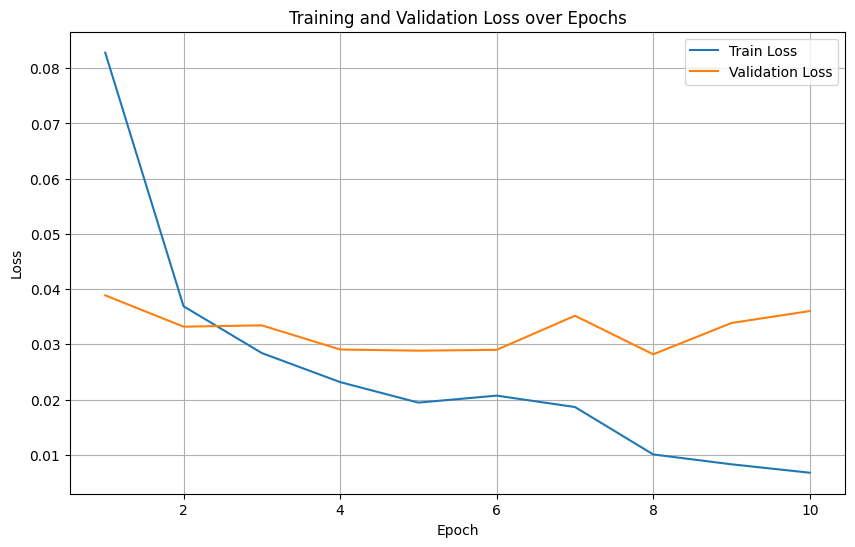


✓ Metrics curve saved to checkpoints_distilbert/finetune_metrics_curve.png


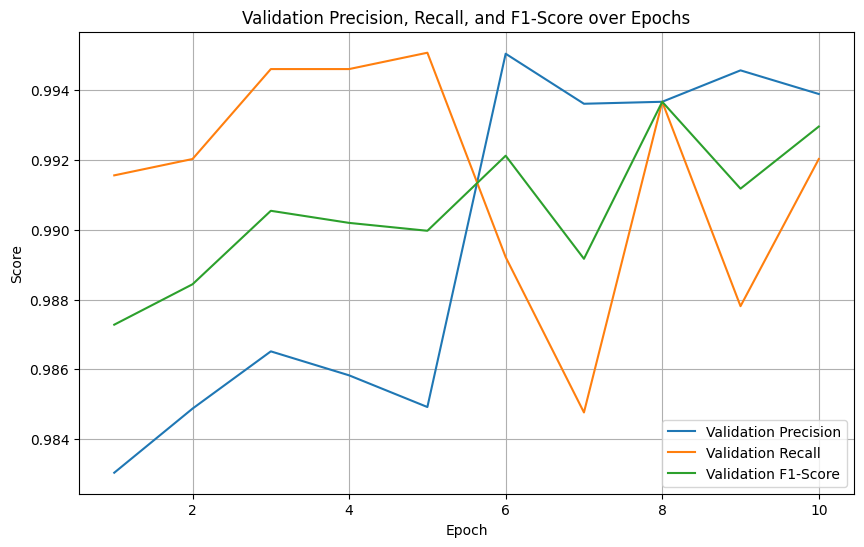

In [16]:

print("TRAINING COMPLETE!")


print("\n" + "="*60)
print("SUMMARY")
print("="*60)

print(f"\n1. Data Processing:")
print(f"   ✓ Train samples: {len(train_df)}")
print(f"   ✓ Validation samples: {len(val_df)}")
print(f"   ✓ Test samples: {len(test_df)}")

print(f"\n2. Fine-tuning (LoRA):")
print(f"   ✓ Epochs trained: {len(finetune_df)}")
print(f"   ✓ Best validation F1: {best_val_f1:.4f}")

print(f"\n3. Logistic Regression:")
print(f"   ✓ Features: 768-dimensional DistilBERT embeddings")
print(f"   ✓ Validation F1: {f1:.4f}")

print(f"\n4. Saved Files:")
print(f"   ✓ {BEST_CKPT_DIR}/lora_weights/")
print(f"   ✓ {BEST_CKPT_DIR}/logistic_regression.pkl")
print(f"   ✓ {BEST_CKPT_DIR}/manifest.json")
print(f"   ✓ {BEST_CKPT_DIR}/tokenizer_config.json")
print(f"   ✓ {CKPT_DIR}/finetune_history.csv")

print("\n" + "="*70)
print(" "*10 + "Model saved! Ready for downstream evaluation.")
print("="*70)

# Display training history
print("\nFine-tuning History:")
print(finetune_df)

#generate graphs showing training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(finetune_df['epoch'], finetune_df['train_loss'], label='Train Loss')
plt.plot(finetune_df['epoch'], finetune_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(CKPT_DIR, 'finetune_loss_curve.png'))
print(f"\n✓ Loss curve saved to {CKPT_DIR}/finetune_loss_curve.png")
plt.show()

#generate graphs showing validation precision, recall, and F1-score over epochs
plt.figure(figsize=(10, 6))
plt.plot(finetune_df['epoch'], finetune_df['val_precision'], label='Validation Precision')
plt.plot(finetune_df['epoch'], finetune_df['val_recall'], label='Validation Recall')
plt.plot(finetune_df['epoch'], finetune_df['val_F1'], label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Precision, Recall, and F1-Score over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(CKPT_DIR, 'finetune_metrics_curve.png'))
print(f"\n✓ Metrics curve saved to {CKPT_DIR}/finetune_metrics_curve.png")
plt.show()